In [187]:
# !pip uninstall pycaret -y   
# !pip install pycaret[full]

In [188]:
import pandas as pd
import numpy as np   
from pycaret.classification import *

In [189]:
# load excel file
df = pd.read_excel('dataset.xlsx', sheet_name='Database')      
# df = df.dropna(axis=0, how='any') # drop rows with NaN values
df

,Name \n(as per NRIC) - Replace with a unique identifier,Type of Registration / Enrolment,Registration / Enrolment Type,Singaporean/ Singapore PR,Race,Gender,Vaccination Status,Experience,Specialisation,Postal Code - to transform using https://www.parliament.gov.sg/mps/find-mps-in-my-constituency,Available work days,Frequency of work,Inpatient Ward(IPS)/ Intensive Care (ICU),Available work timing,Assigned Department,Assigned Supervisor - Replace with unique identifier,"Supervisor's rating on Locum Perfomance\nPoor, Below Average, Average, Above Average, Excellent\n(1 - 5)",Comments on \nLocum Perfomance,Recommend to Rehire\n(Yes/No)
0,Chong Zhiqing,Enrolled Nurse,General (Conditional),Singaporean,Chinese,Female,Fully Vaccinated,Nursing Home / Community Treatment facility,Community Health,Tampines GRC,Weekdays,Six times a week,IPS,No Preference,IPS 7,Peter,3,Reliable / going extra mile to serve patients,Yes
1,Chong Zhiqing,Registered Nurse,General,Singaporean,Chinese,Female,Partially Vaccinated,Nursing Home / Community Treatment facility,Community Health,Tampines GRC,Weekdays,Six times a week,IPS,No Preference,IPS 7,Peter,3,Reliable / going extra mile to serve patients,Yes
2,Chong Zhiqing,Enrolled Nurse,General (Conditional),Singaporean,Chinese,Female,Fully Vaccinated,Nursing Home / Community Treatment facility,Community Health,Tampines GRC,Weekdays,Six times a week,IPS,No Preference,IPS 7,Peter,3,Reliable / going extra mile to serve patients,Yes
3,Chong Zhiqing,Registered Nurse,General (Conditional),Singaporean,Chinese,Female,Partially Vaccinated,Nursing Home / Community Treatment facility,Community Health,Tampines GRC,Weekdays,Six times a week,IPS,No Preference,IPS 7,Peter,3,Reliable / going extra mile to serve patients,Yes
4,Chong Zhiqing,Enrolled Nurse,General,Singaporean,Chinese,Female,Fully Vaccinated,Nursing Home / Community Treatment facility,Community Health,Tampines GRC,Weekdays,Six times a week,IPS,No Preference,IPS 7,Peter,3,Reliable / going extra mile to serve patients,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
241,Shekirih,NaN,NaN,Singaporean,Malay,Female,Partially Vaccinated,Day ward,Community Health,Marsiling-Yew Tee GRC,Weekdays,Five times a week,IPS,8.30pm to 7.30am,IPS 7,Peter,2,Lack of commitment,yes
242,Shekirih,NaN,NaN,Singaporean,Malay,Female,Fully Vaccinated,Day ward,Community Health,Marsiling-Yew Tee GRC,Weekdays,Five times a week,IPS,8.30pm to 7.30am,IPS 7,Peter,2,Lack of commitment,yes
243,Stepfine Ng,NaN,NaN,Singaporean,Chinese,Female,Partially Vaccinated,Day ward,Community Health,Ang Mo Kio GRC,Weekdays,Five times a week,IPS,No Preference,IPS 8,Peter,3,Reliable,yes
244,Stepfine Ng,NaN,NaN,Singaporean,Chinese,Female,Fully Vaccinated,Day ward,Community Health,Ang Mo Kio GRC,Weekdays,Five times a week,IPS,No Preference,IPS 8,Peter,3,Reliable,yes


##### this project is to train ensemble model to generate a suiability score for a given nurse and job(icu or ips) based on a few of nurse features

In [190]:
def calculate_suitability(row):
    # define logic for calculating suitability 
    x = 1
    if row['Vaccination Status'] == 'Fully Vaccinated':
        x += 10
    if row['Recommend to Rehire\n(Yes/No)'] == 'Yes':  
        x += 6
    if row['Vaccination Status'] == 'Partially Vaccinated':
        x -= 3    
    if row['Vaccination Status'] == 'Not Vaccinated':
        x -= 6        
    grc_dict = {'Aljunied GRC': 6, 'Jalan Besar GRC': 9, 'Pasir Ris-Punggol GRC': 4, 'Tanjong Pagar GRC': 8, 'Tampines GRC': 2, 'Ang Mo Kio GRC': 5, 'East Coast GRC': 3, 'Marsiling-Yew Tee GRC': 1 ,'Sengkang GRC':7 }
    for key, value in grc_dict.items():
        if row['Postal Code - to transform using https://www.parliament.gov.sg/mps/find-mps-in-my-constituency'] == key:
            x += value
            
    x = int(row["Supervisor's rating on Locum Perfomance\nPoor, Below Average, Average, Above Average, Excellent\n(1 - 5)"]) + x   

    return x    
    
# apply the function to each row in the DataFrame
df['suitability rating'] = df.apply(calculate_suitability, axis=1)

In [191]:
# get the column names          
cols = df.columns.values.tolist()
cols

['Name \n(as per NRIC)  - Replace  with a unique identifier',
 'Type of Registration / Enrolment',
 'Registration / Enrolment Type',
 'Singaporean/ Singapore PR',
 'Race',
 'Gender',
 'Vaccination Status',
 'Experience',
 ' Specialisation',
 'Postal Code - to transform using https://www.parliament.gov.sg/mps/find-mps-in-my-constituency',
 'Available work days',
 'Frequency of work ',
 'Inpatient Ward(IPS)/ Intensive Care (ICU)',
 'Available work timing ',
 'Assigned Department ',
 'Assigned Supervisor - Replace with unique identifier',
 "Supervisor's rating on Locum Perfomance\nPoor, Below Average, Average, Above Average, Excellent\n(1 - 5)",
 'Comments on \nLocum Perfomance',
 'Recommend to Rehire\n(Yes/No)',
 'suitability rating']

In [192]:
df_model = df[['Race',
               'Gender',
               'Vaccination Status',
               'Postal Code - to transform using https://www.parliament.gov.sg/mps/find-mps-in-my-constituency',
               'Available work timing ',
               'suitability rating',
                   ]]

In [193]:
df_model['suitability rating'] = df_model['suitability rating'].astype(int)     
df_model['suitability rating'].value_counts() 

20    23
10    23
17    23
7     22
18    21
19    17
28    16
13    16
23    15
12    14
22    13
9     11
29     8
8      6
11     4
21     3
5      3
15     3
14     3
4      2
Name: suitability rating, dtype: int64

In [194]:
# make he values intto from range 0 to 5 using pandfas cut function         
df_model['suitability rating'] = pd.cut(df_model['suitability rating'], bins=[1, 8, 13, 17, 24, 30], labels=['terrible choice', 'not suitable', 'mediocre', 'suitable', 'highly suitable'])    

In [195]:
df_model['suitability rating'].value_counts()   

suitable           92
not suitable       68
terrible choice    33
mediocre           29
highly suitable    24
Name: suitability rating, dtype: int64

In [196]:
# diaplayyyyy ttthe statts of suiabili score 
df_model['suitability rating'].describe()       

count          246
unique           5
top       suitable
freq            92
Name: suitability rating, dtype: object

In [197]:
df_model

,Race,Gender,Vaccination Status,Postal Code - to transform using https://www.parliament.gov.sg/mps/find-mps-in-my-constituency,Available work timing,suitability rating
0,Chinese,Female,Fully Vaccinated,Tampines GRC,No Preference,suitable
1,Chinese,Female,Partially Vaccinated,Tampines GRC,No Preference,not suitable
2,Chinese,Female,Fully Vaccinated,Tampines GRC,No Preference,suitable
3,Chinese,Female,Partially Vaccinated,Tampines GRC,No Preference,not suitable
4,Chinese,Female,Fully Vaccinated,Tampines GRC,No Preference,suitable
...,...,...,...,...,...,...
241,Malay,Female,Partially Vaccinated,Marsiling-Yew Tee GRC,8.30pm to 7.30am,terrible choice
242,Malay,Female,Fully Vaccinated,Marsiling-Yew Tee GRC,8.30pm to 7.30am,mediocre
243,Chinese,Female,Partially Vaccinated,Ang Mo Kio GRC,No Preference,not suitable
244,Chinese,Female,Fully Vaccinated,Ang Mo Kio GRC,No Preference,suitable


In [198]:
from sklearn.model_selection import train_test_split

# use the training data in setup
clf1 = setup(data = df_model, target = 'suitability rating', session_id=123)     
# compare all models    
best_model = compare_models()

# save the best model  
save_model(best_model, 'final_model')

,Description,Value
0,Session id,123
1,Target,suitability rating
2,Target type,Multiclass
3,Target mapping,"highly suitable: 0, mediocre: 1, not suitable: 2, suitable: 3, terrible choice: 4"
4,Original data shape,"(221, 6)"
5,Transformed data shape,"(221, 16)"
6,Transformed train set shape,"(154, 16)"
7,Transformed test set shape,"(67, 16)"
8,Ordinal features,3
9,Categorical features,5


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
xgboost,Extreme Gradient Boosting,0.8771,0.9752,0.8771,0.8964,0.8654,0.8294,0.8420,0.1390
dt,Decision Tree Classifier,0.8767,0.9735,0.8767,0.8884,0.8676,0.8296,0.8396,0.0300
et,Extra Trees Classifier,0.8767,0.9735,0.8767,0.8884,0.8676,0.8296,0.8396,0.0830
catboost,CatBoost Classifier,0.8767,0.9781,0.8767,0.8884,0.8676,0.8296,0.8396,0.7220
lightgbm,Light Gradient Boosting Machine,0.8762,0.9621,0.8762,0.8808,0.8623,0.8278,0.8398,0.1690
rf,Random Forest Classifier,0.8638,0.9714,0.8638,0.8808,0.8543,0.8104,0.8222,0.0920
gbc,Gradient Boosting Classifier,0.8638,0.9719,0.8638,0.8808,0.8543,0.8104,0.8222,0.1070
lda,Linear Discriminant Analysis,0.8571,0.9645,0.8571,0.8594,0.8455,0.8062,0.8161,0.0290
lr,Logistic Regression,0.8504,0.9631,0.8504,0.8595,0.8362,0.7909,0.8043,0.0400
knn,K Neighbors Classifier,0.8117,0.9396,0.8117,0.8191,0.8023,0.7398,0.7477,0.0440


Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('label_encoding',
                  TransformerWrapperWithInverse(exclude=None, include=None,
                                                transformer=LabelEncoder())),
                 ('numerical_imputer',
                  TransformerWrapper(exclude=None, include=[],
                                     transformer=SimpleImputer(add_indicator=False,
                                                               copy=True,
                                                               fill_value=None,
                                                               keep_empty_features=False,
                                                               missing_values=nan,
                                                               strategy='mean',
                                                               verbo...
                                importance_type=None,
                                interaction_constra

In [199]:
# use he best model to predict the test data    
predictions = predict_model(best_model, data=df_model[:1])   
predictions

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extreme Gradient Boosting,1.0000,0,1.0000,1.0000,1.0000,nan,0.0000


,Race,Gender,Vaccination Status,Postal Code - to transform using https://www.parliament.gov.sg/mps/find-mps-in-my-constituency,Available work timing,suitability rating,prediction_label,prediction_score
0,Chinese,Female,Fully Vaccinated,Tampines GRC,No Preference,suitable,suitable,0.9865


In [204]:
from pycaret.classification import load_model, predict_model
import pandas as pd

# load model        
model = load_model('final_model')

# input nurse details via code and feed into model to predict score
nurse = {
    "Race": ["Malay"],
    "Gender": ["Female"],
    "Vaccination Status": ["Partially Vaccinated"],
    "Experience": ["Community Health"],
    " Specialisation": ["Chronic Disease Management"],
    "Postal Code - to transform using https://www.parliament.gov.sg/mps/find-mps-in-my-constituency": ["Tampines GRC"],
    "Available work timing ": ["five times a week"]
}

# create a dataframe to store the input data
df_nurse = pd.DataFrame(nurse)

# use the model to make a prediction
prediction = predict_model(model, data=df_nurse)


# print the predicted rating
print(prediction)

Transformation Pipeline and Model Successfully Loaded


    Race  Gender    Vaccination Status        Experience  \
0  Malay  Female  Partially Vaccinated  Community Health   

               Specialisation  \
0  Chronic Disease Management   

  Postal Code - to transform using https://www.parliament.gov.sg/mps/find-mps-in-my-constituency  \
0                                       Tampines GRC                                               

  Available work timing  prediction_label  prediction_score  
0      five times a week         suitable            0.6412  


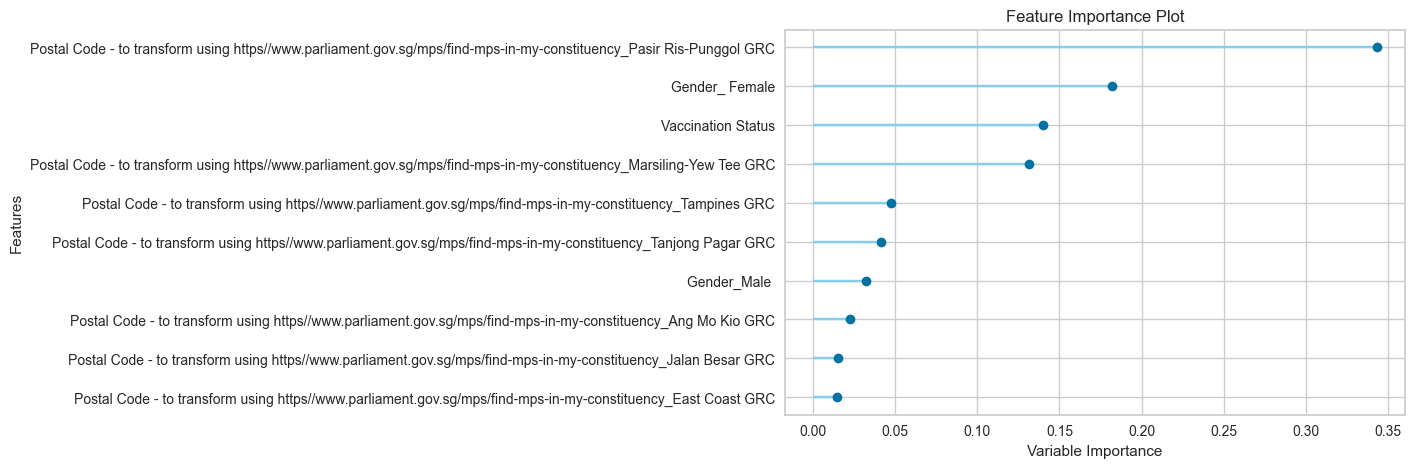

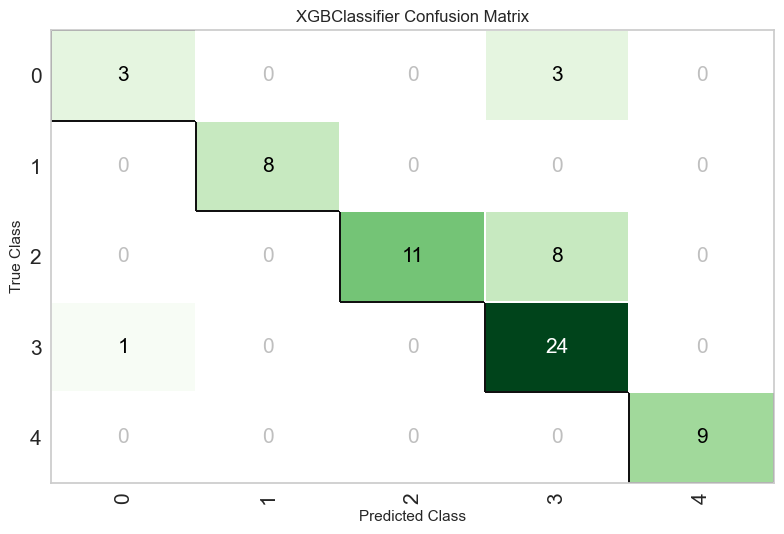

In [202]:
# see which feaures are important
plot_model(model, plot='feature')  
plot_model(model, plot='confusion_matrix')                

  

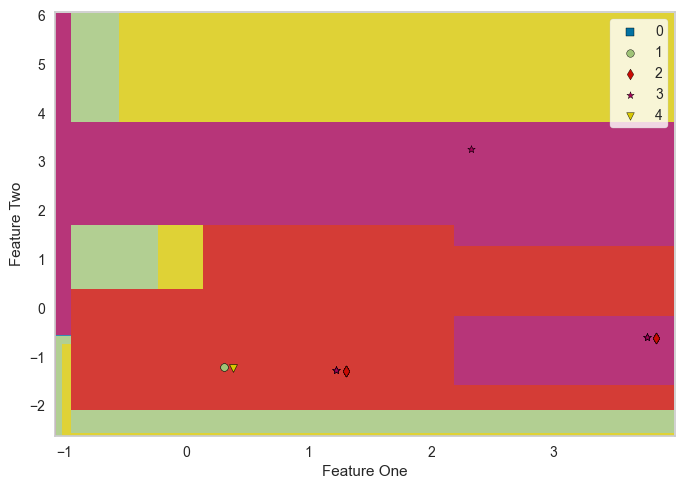

In [175]:
#view the catboost model    
plot_model(model, plot='boundary')